In [1]:
import torch
from load_data import *
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
device = torch.device('cuda:0')

In [4]:
Xtr, Xte, ytr, yte, Ztr, Zte = load_german_data(random_state=42)
ytr = ytr.astype('float32').reshape((-1,1))
yte = yte.astype('float32').reshape((-1,1))

In [5]:
print("sensitive ratio: ",sum(Ztr==0)/len(Ztr))
print("training default: ", sum(ytr==0)/len(ytr))
print("test default: ", sum(yte==0)/len(yte))
print('# training samples:', Xtr.shape)
print('# test samples:', Xte.shape)
print('# sensitive vars', Ztr.shape)
print('# output vars', ytr.shape)

sensitive ratio:  [0.18571429]
training default:  [0.29714286]
test default:  [0.30666667]
# training samples: (700, 23)
# test samples: (300, 23)
# sensitive vars (700, 1)
# output vars (700, 1)


In [6]:
Xrs = np.row_stack([Xtr,Xte])
print(Xrs.shape)
print(np.unique(Xrs,axis=0).shape)

(1000, 23)
(1000, 23)


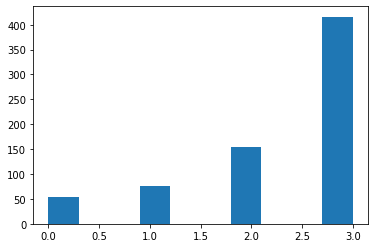

In [10]:
import matplotlib.pyplot as plt
yz_tr = ytr+Ztr*2
plt.hist(yz_tr)
plt.show()

In [8]:
N1 = 700
Xtr1, ytr1, Ztr1, Xtr2, ytr2, Ztr2 = split_initial_dataset(Xtr,ytr,Ztr,N_init=N1,random_state=42)

In [9]:
print("sensitive ratio: ",sum(Ztr==0)/len(Ztr))
print("training init: ", sum(ytr1==0)/len(ytr1))
print("select init: ", sum(ytr2==0)/len(ytr2))
print("test default: ", sum(yte==0)/len(yte))

sensitive ratio:  [0.18571429]
training init:  [0.29714286]


ZeroDivisionError: division by zero

In [11]:
from fairNN_train import *
from load_data import *
from fair_eval import *

In [12]:
class Args:
    def __init__(self):
        self.epochs = 20
#         self.max_epochs = None
        self.AL_iters = 10 # AL batch 몇 번 뽑는지?
        self.AL_batch = 32 # AL 시에 select 되는 데이터 수
        self.batch_size = 64
        self.AL_select = 'acc'
        self.num_classes = 2
#         self.AL_valid = 32
        
    def print_args(self):
        print("train epochs/batch: {}/{}".format(self.epochs,self.batch_size))
        print("AL iters/batch: {}/{}".format(self.AL_iters,self.AL_batch))
        print("AL selection is based on ", self.AL_select)

In [13]:
from fairAL_utils import *

In [14]:
args = Args()
train_data = NPsDataSet(Xtr1, ytr1, Ztr1)
train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True, drop_last=False)
zZtr2 = transform_dum2cat(Ztr2)
select_data = NPsDataSet(Xtr2, ytr2, zZtr2)
select_loader = DataLoader(select_data, batch_size=args.batch_size, shuffle=False, drop_last=False)
test_data = NPsDataSet(Xte, yte, Zte)
test_loader = DataLoader(test_data, batch_size=args.batch_size, shuffle=False, drop_last=False)

In [15]:
n_features = train_data.tensors[0].shape[1]
clf = Classifier(n_features=n_features)
clf.to(device)

Classifier(
  (network): Sequential(
    (0): Linear(in_features=23, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [16]:
clf_criterion = nn.BCELoss()
clf_optimizer = optim.Adam(clf.parameters())
liveloss = PlotLosses()

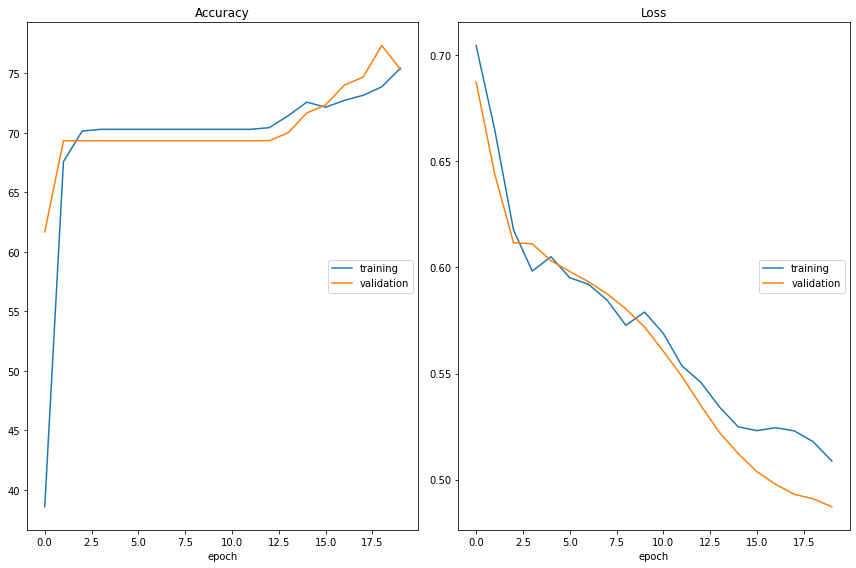

Accuracy
	training         	 (min:   38.571, max:   75.429, cur:   75.429)
	validation       	 (min:   61.667, max:   77.333, cur:   75.333)
Loss
	training         	 (min:    0.509, max:    0.704, cur:    0.509)
	validation       	 (min:    0.487, max:    0.687, cur:    0.487)
Finished Training


In [17]:
train_model(clf, train_loader, clf_criterion,clf_optimizer, device, args.epochs, test_loader,liveloss)
torch.save(clf.state_dict(),"../results/german/AL_iter_2.ckpt") # 모든 애들을 다 0으로 예측함

In [15]:
clf.load_state_dict(torch.load("../results/german/AL_iter_2.ckpt"))

<All keys matched successfully>

# Visualize the trained model

In [19]:
clf.eval()
from torchsummary import summary
summary(clf.to('cuda:0'),(23,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             768
              ReLU-2                   [-1, 32]               0
           Dropout-3                   [-1, 32]               0
            Linear-4                   [-1, 32]           1,056
              ReLU-5                   [-1, 32]               0
           Dropout-6                   [-1, 32]               0
            Linear-7                   [-1, 32]           1,056
              ReLU-8                   [-1, 32]               0
           Dropout-9                   [-1, 32]               0
           Linear-10                    [-1, 1]              33
Total params: 2,913
Trainable params: 2,913
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total

In [20]:
param_names = ['lin1_w','lin1_b','lin2_w',' lin2_b','lin3_w','lin3_b','lin4_w','lin4_b']

# instance-level gradient

In [21]:
from viz_utils import *

In [22]:
train_data = NPsDataSet(Xtr1, ytr1, Ztr1)
train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=False, drop_last=False)
zZtr2 = transform_dum2cat(Ztr2)
select_data = NPsDataSet(Xtr2, ytr2, zZtr2)
select_loader = DataLoader(select_data, batch_size=args.batch_size, shuffle=False, drop_last=False)
test_data = NPsDataSet(Xte, yte, Zte)
test_loader = DataLoader(test_data, batch_size=args.batch_size, shuffle=False, drop_last=False)

In [23]:
import numpy as np
import torch.nn as nn

class LogitSum(nn.Module):
    def __init__(self,reduce=True):
        super(LogitSum,self).__init__()
        self.reduce=reduce
    def forward(self,output):
        loss = output
        if self.reduce:
            return loss.sum()
        else:
            return loss

In [24]:
bn_criterion = BinaryEntropy()
lg_criterion = LogitSum()

In [25]:
out_tr, y_tr, z_tr, wgrad_tr, grdic_tr = compute_grad_arrs(clf, train_loader, clf_criterion, device, param_names)
out_te, y_te, z_te, wgrad_te, grdic_te = compute_grad_arrs(clf, test_loader, clf_criterion, device, param_names)

In [26]:
out_tr2, y_tr2, z_tr2, wgrad_tr2, grdic_tr2 = compute_predgrad_arrs(clf, train_loader, clf_criterion, device, param_names)
out_te2, y_te2, z_te2, wgrad_te2, grdic_te2 = compute_predgrad_arrs(clf, test_loader, clf_criterion, device, param_names)

In [27]:
out_tr3, y_tr3, z_tr3, wgrad_tr3, grdic_tr3 = compute_predgrad_arrs(clf, train_loader, bn_criterion, device, param_names,True)
out_te3, y_te3, z_te3, wgrad_te3, grdic_te3 = compute_predgrad_arrs(clf, test_loader, bn_criterion, device, param_names,True)

In [28]:
out_tr4, y_tr4, z_tr4, wgrad_tr4, grdic_tr4 = compute_predgrad_arrs(clf, train_loader, lg_criterion, device, param_names,True)
out_te4, y_te4, z_te4, wgrad_te4, grdic_te4 = compute_predgrad_arrs(clf, test_loader, lg_criterion, device, param_names,True)

In [30]:
wgrad_tr4.shape

(10000, 3617)

In [29]:
from sklearn.metrics.pairwise import cosine_similarity
def corr_grad(grad_arr,y,z):
    mgrad = np.mean(grad_arr,axis=0)
    mgrad_y0 = np.mean(grad_arr[y==0],axis=0)
    mgrad_y1 = np.mean(grad_arr[y==1],axis=0)
    mgrad_z0 = np.mean(grad_arr[z==0],axis=0)
    mgrad_z1 = np.mean(grad_arr[z==1],axis=0)
    aa = [mgrad,mgrad_y0,mgrad_y1,mgrad_z0,mgrad_z1]
    for a in aa:
        print(np.linalg.norm(a))
    aan = np.row_stack(aa)
    print(cosine_similarity(aan,aan))

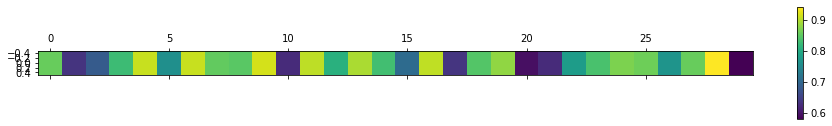

In [31]:
st_idx = 0
ds_idx = 30
sim_mat4 = cosine_similarity(np.expand_dims(np.mean(wgrad_te4,axis=0),axis=0), wgrad_te4)
plt.matshow(sim_mat4[:,st_idx:ds_idx])
plt.colorbar()

In [33]:
print(np.sum(np.dot(np.expand_dims(np.mean(wgrad_te4,axis=0),axis=0),wgrad_te4.T)<0))

0


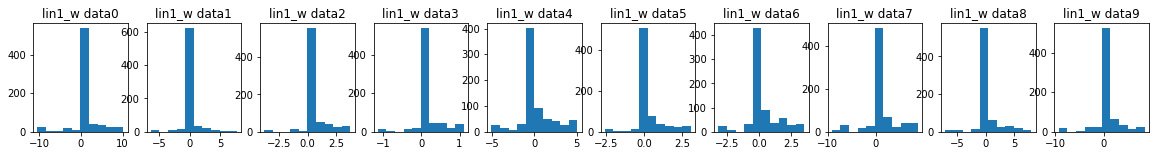

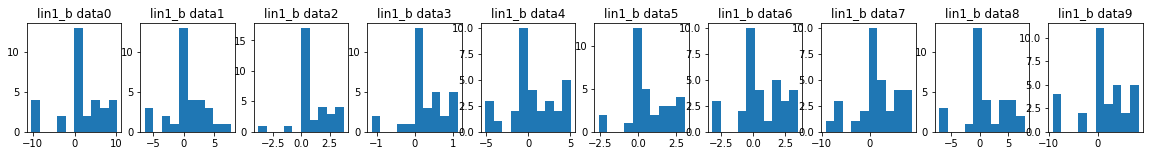

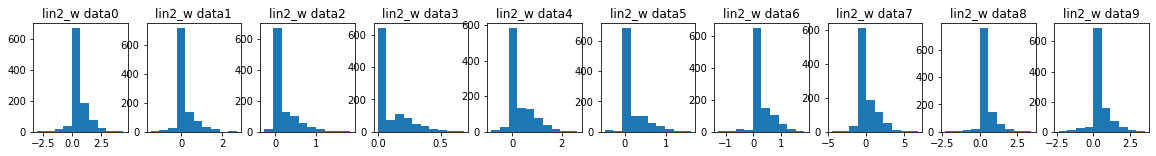

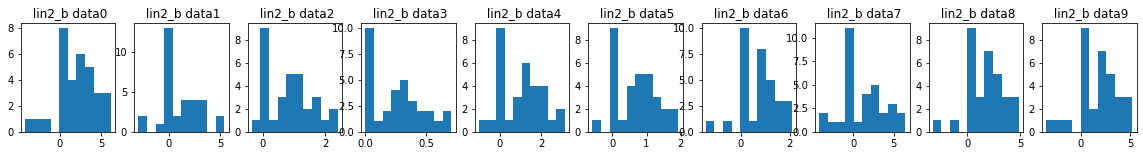

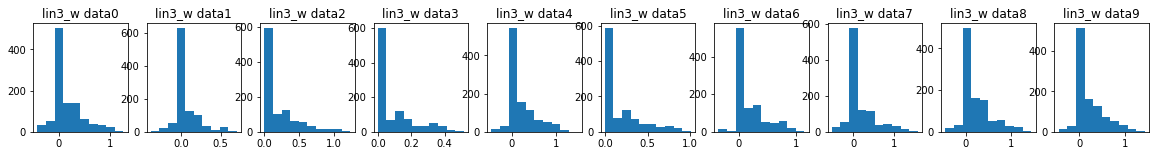

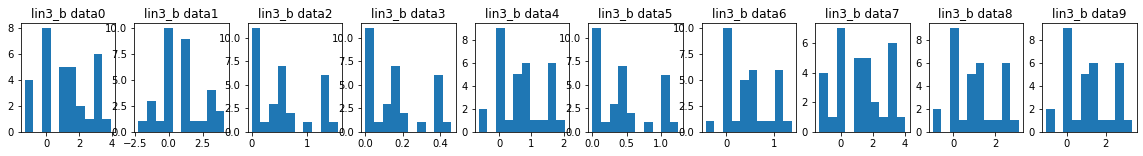

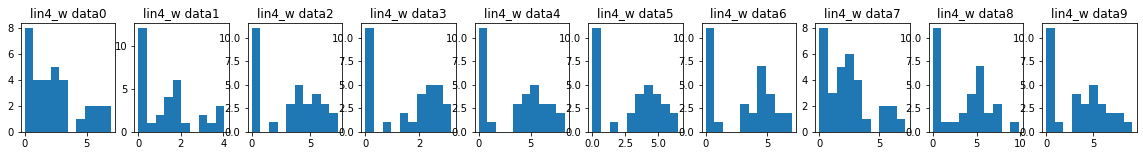

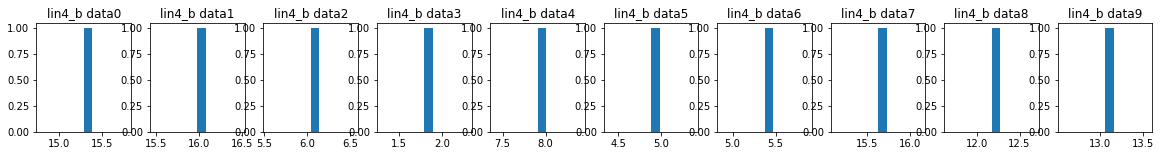

In [35]:
st_idx = 0
ds_idx = 10
for k in grdic_te4:
    fig,axs = plt.subplots(1,ds_idx,figsize=(20,2))
    for j in range(ds_idx):
        axs[j].hist(grdic_te4[k][j])
        axs[j].set_title(k+' data'+str(j))
    plt.show()

In [84]:
print(test_data.tensors[0].shape)

torch.Size([13564, 45])


In [86]:
print(sim_matp.shape)
print(sim_marp.shape)

(13564, 13564)
(1, 1)


In [91]:
np.unravel_index(np.argmax(sim_marp),sim_marp.shape)

(2761, 2761)

In [95]:
max(grdic_te4[param_names[-1]])

array([16.], dtype=float32)

In [109]:
# np.eye(wgrad_te4.shape[0]).shape
# print(wgrad_te4.shape[0])
print(np.ones((wgrad_te4.shape[0],wgrad_te4.shape[0])))

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [36]:
mask_mat = np.ones((wgrad_te4.shape[0],wgrad_te4.shape[0])) - np.eye(wgrad_te4.shape[0])

In [37]:
print(mask_mat)

[[0. 1. 1. ... 1. 1. 1.]
 [1. 0. 1. ... 1. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 0. 1.]
 [1. 1. 1. ... 1. 1. 0.]]


0.0 0.0 44850.0


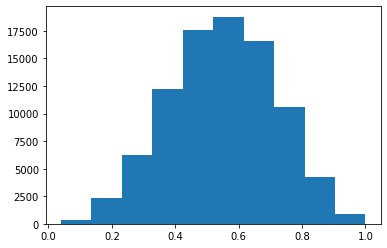

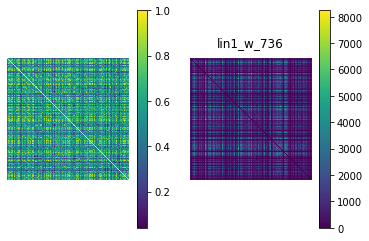

0.0 0.0 44850.0


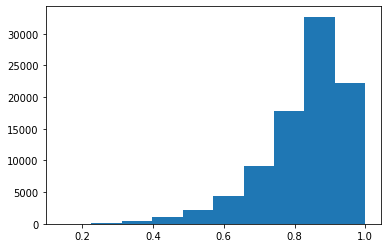

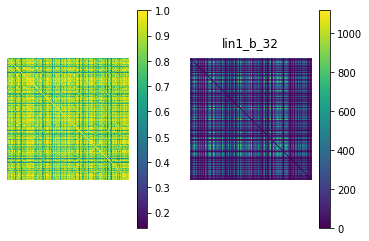

0.0 0.0 44850.0


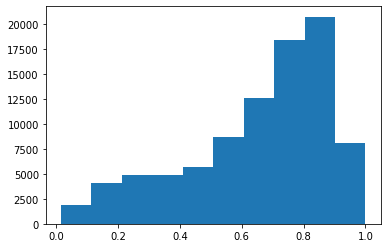

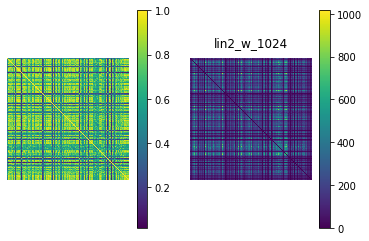

0.0 0.0 44850.0


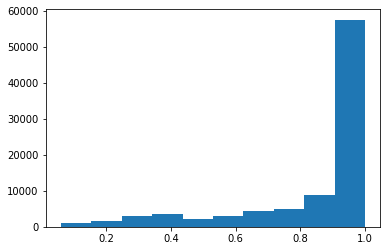

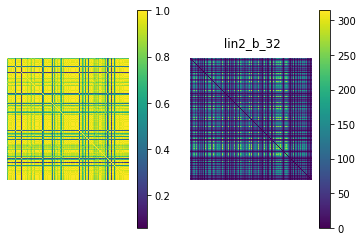

0.0 0.0 44850.0


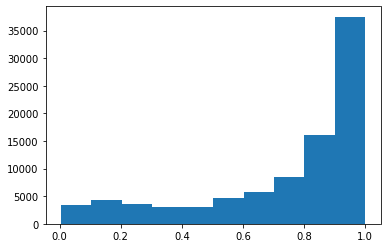

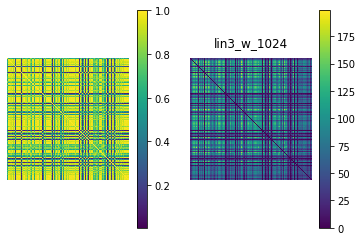

0.0 0.0 44850.0


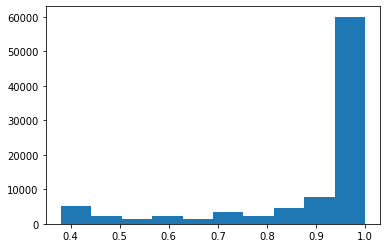

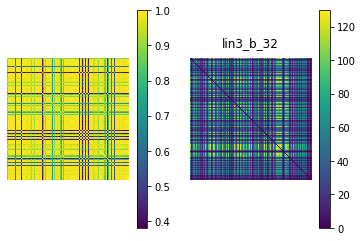

0.0 0.0 44850.0


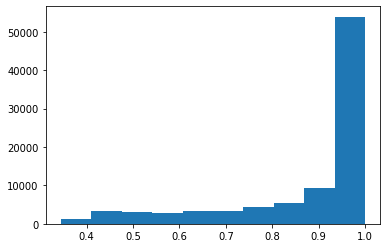

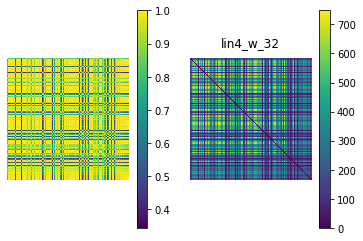

0.0 0.0 44850.0


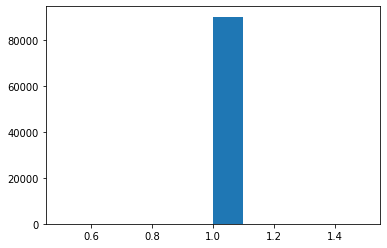

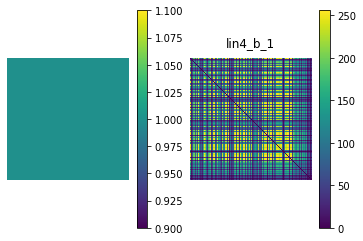

In [38]:

for k in grdic_te4:
    sim_matp = cosine_similarity(grdic_te4[k], grdic_te4[k])
    sim_marp = np.dot(grdic_te4[k], grdic_te4[k].T)
    sim_marp = sim_marp*mask_mat
    print(np.min(sim_marp), np.sum(sim_marp<0)/2,np.sum(sim_marp>0)/2)
    plt.hist(sim_matp.ravel())
    plt.show()
    fig,axs = plt.subplots(1,2)
    im0 = axs[0].matshow(sim_matp)
    axs[0].axis('off')
    fig.colorbar(im0,ax=axs[0])
    im1 = axs[1].matshow(sim_marp)
    axs[1].axis('off')
    fig.colorbar(im1,ax=axs[1])
    plt.title(k+'_'+str(grdic_te4[k].shape[1]))
    plt.show()    

-173.95831298828125 103.0 4836.0


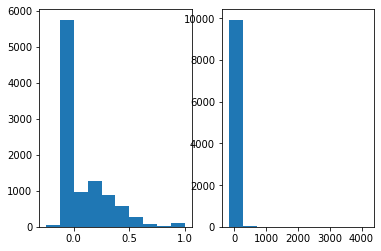

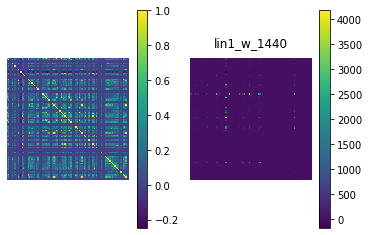

-52.25019836425781 103.0 4836.0


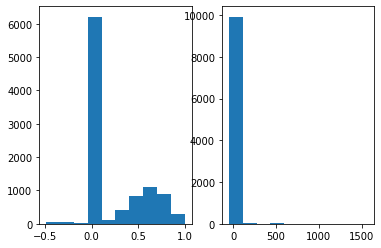

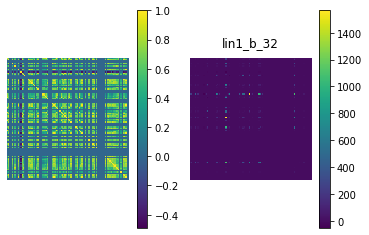

-47.1080436706543 10.0 4841.0


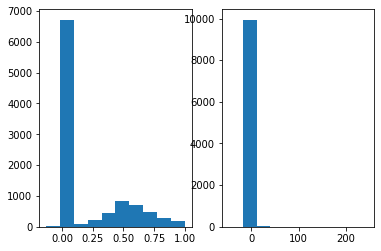

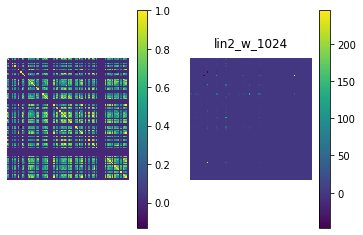

-87.22699737548828 11.0 4851.0


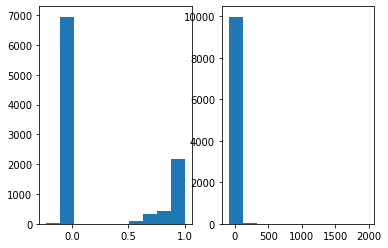

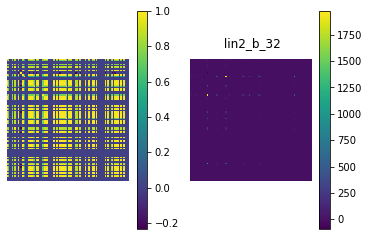

0.0 0.0 4862.0


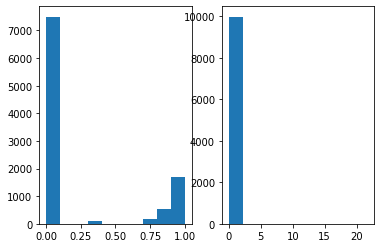

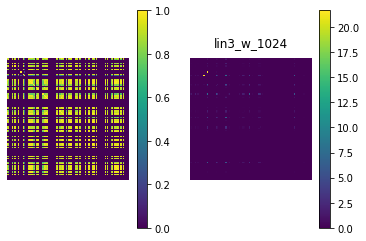

0.0 0.0 4950.0


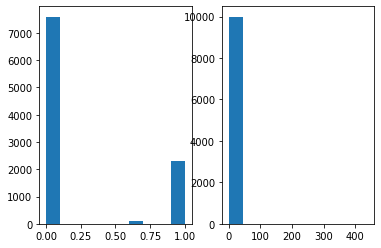

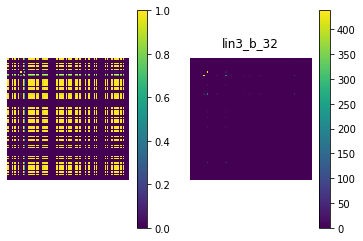

0.0 0.0 4950.0


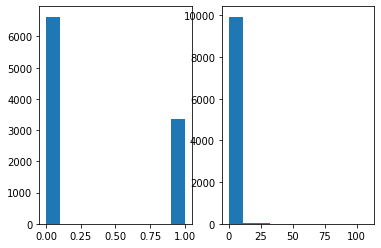

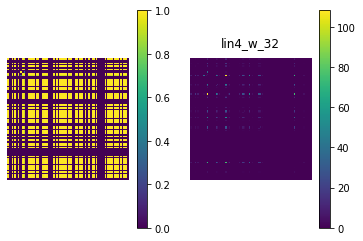

0.0 0.0 4950.0


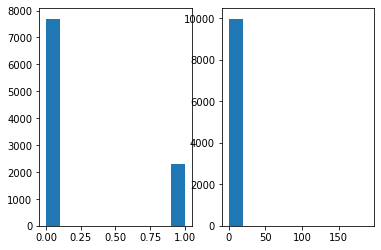

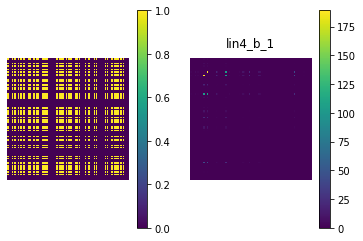

In [124]:
st_idx = 0
ds_idx = 100
for k in grdic_te4:
    sim_matp = cosine_similarity(grdic_te4[k][st_idx:ds_idx], grdic_te4[k][st_idx:ds_idx])
    sim_marp = np.dot(grdic_te4[k][st_idx:ds_idx], grdic_te4[k][st_idx:ds_idx].T)
    sim_marp = sim_marp*mask_mat[st_idx:ds_idx,st_idx:ds_idx]
    print(np.min(sim_marp), np.sum(sim_marp<0)/2,np.sum(sim_marp>0)/2)
    fig,axs = plt.subplots(1,2)
    axs[0].hist(sim_matp.ravel())
    axs[1].hist(sim_marp.ravel())
    plt.show()
    fig,axs = plt.subplots(1,2)
    im0 = axs[0].matshow(sim_matp)
    axs[0].axis('off')
    fig.colorbar(im0,ax=axs[0])
    im1 = axs[1].matshow(sim_marp)
    axs[1].axis('off')
    fig.colorbar(im1,ax=axs[1])
    plt.title(k+'_'+str(grdic_te4[k].shape[1]))
    plt.show()    

-250.041748046875 11.0 4925.0


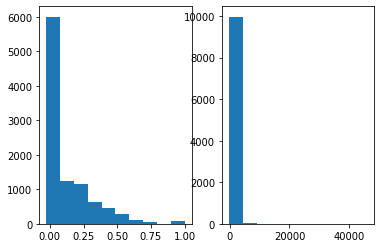

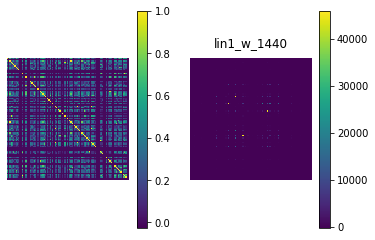

-114.30081939697266 11.0 4925.0


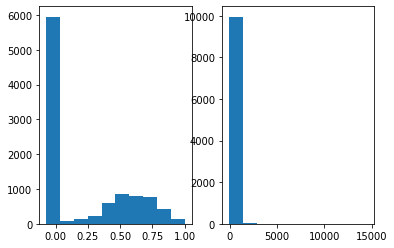

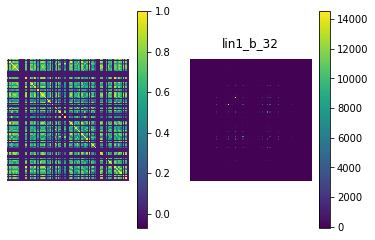

0.0 0.0 4936.0


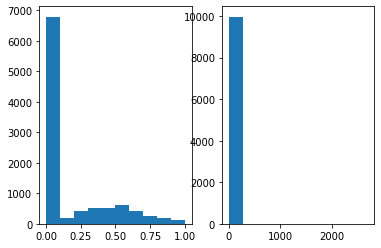

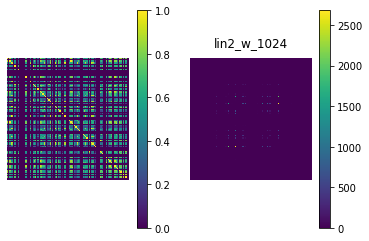

0.0 0.0 4950.0


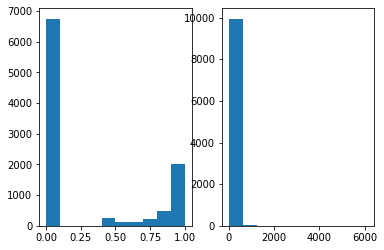

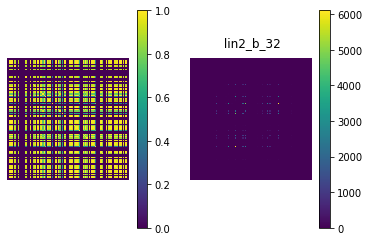

0.0 0.0 4950.0


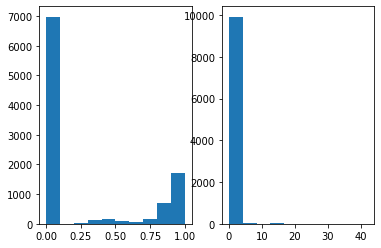

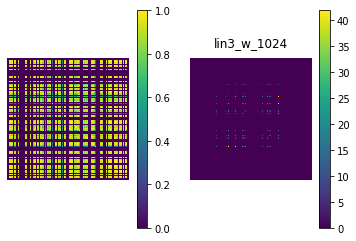

0.0 0.0 4950.0


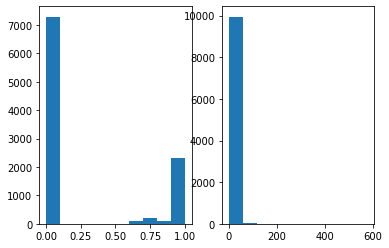

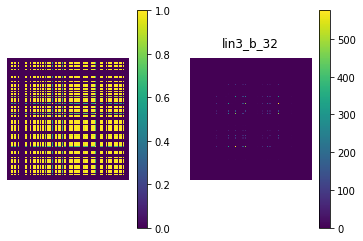

0.0 0.0 4950.0


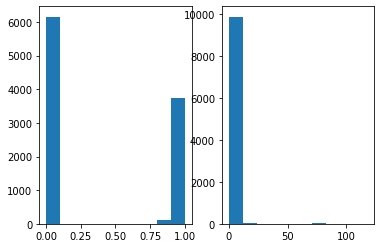

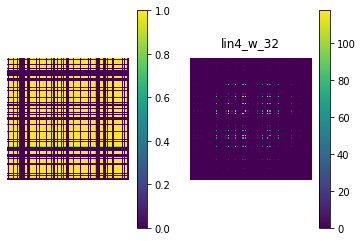

0.0 0.0 4950.0


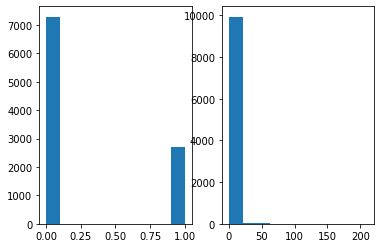

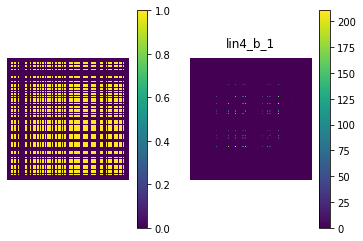

In [125]:
st_idx = 0
ds_idx = 100
for k in grdic_tr4:
    sim_matp = cosine_similarity(grdic_tr4[k][st_idx:ds_idx], grdic_tr4[k][st_idx:ds_idx])
    sim_marp = np.dot(grdic_tr4[k][st_idx:ds_idx], grdic_tr4[k][st_idx:ds_idx].T)
    sim_marp = sim_marp*mask_mat[st_idx:ds_idx,st_idx:ds_idx]
    print(np.min(sim_marp), np.sum(sim_marp<0)/2,np.sum(sim_marp>0)/2)
    fig,axs = plt.subplots(1,2)
    axs[0].hist(sim_matp.ravel())
    axs[1].hist(sim_marp.ravel())
    plt.show()
    fig,axs = plt.subplots(1,2)
    im0 = axs[0].matshow(sim_matp)
    axs[0].axis('off')
    fig.colorbar(im0,ax=axs[0])
    im1 = axs[1].matshow(sim_marp)
    axs[1].axis('off')
    fig.colorbar(im1,ax=axs[1])
    plt.title(k+'_'+str(grdic_te4[k].shape[1]))
    plt.show()    

(13564, 13564)


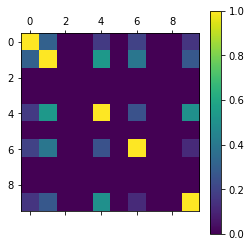

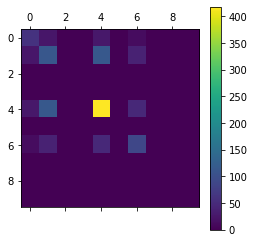

In [66]:
st_idx = 0
ds_idx = 10
sim_matt4 = cosine_similarity(wgrad_te4, wgrad_te4)
sim_mait4 = np.dot(wgrad_te4,wgrad_te4.T)
print(sim_mait4.shape)
plt.matshow(sim_matt4[st_idx:ds_idx,st_idx:ds_idx])
plt.colorbar()
plt.matshow(sim_mait4[st_idx:ds_idx,st_idx:ds_idx])
plt.colorbar()


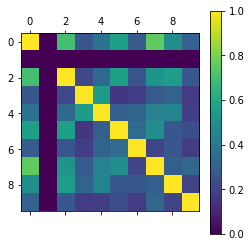

In [42]:
st_idx = 0
ds_idx = 10
sim_matr4 = cosine_similarity(wgrad_tr4, wgrad_tr4)
plt.matshow(sim_matr4[st_idx:ds_idx,st_idx:ds_idx])
plt.colorbar()

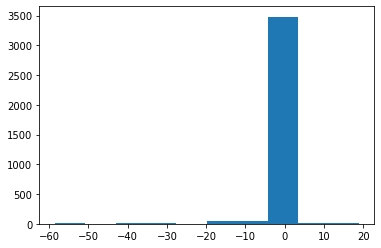

In [45]:
plt.hist(wgrad_tr4[31])
plt.show()

In [41]:
sim_matt4[:2,:10]

array([[9.9999988e-01, 3.0907422e-01, 2.8559230e-14, 1.9392102e-08,
        1.6986509e-01, 5.6058563e-10, 1.9573006e-01, 2.7705583e-12,
        9.3007807e-10, 1.5596244e-01],
       [3.0907422e-01, 9.9999988e-01, 2.9803220e-14, 5.5852134e-08,
        5.3299636e-01, 1.0706531e-09, 3.9451161e-01, 3.3561016e-12,
        2.1433821e-09, 2.7576339e-01]], dtype=float32)

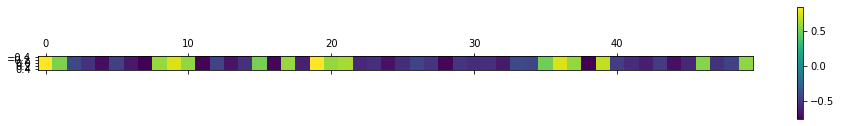

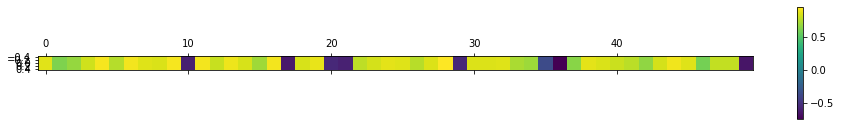

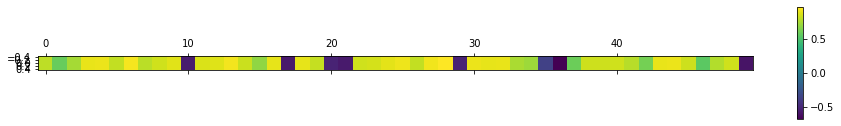

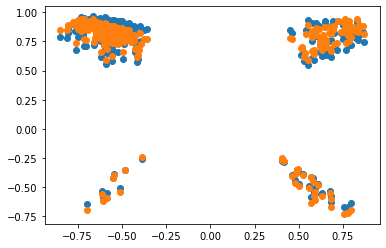

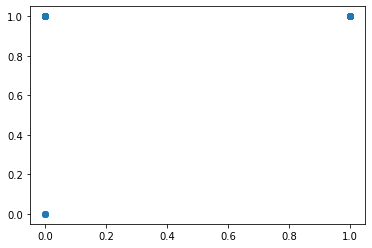

In [39]:
st_idx = 0
ds_idx = 50
sim_mat = cosine_similarity(np.expand_dims(np.mean(wgrad_te,axis=0),axis=0), wgrad_te)
plt.matshow(sim_mat[st_idx:ds_idx,st_idx:ds_idx])
plt.colorbar()
plt.show()
sim_mat2 = cosine_similarity(np.expand_dims(np.mean(wgrad_te2,axis=0),axis=0), wgrad_te2)
plt.matshow(sim_mat2[st_idx:ds_idx,st_idx:ds_idx])
plt.colorbar()
plt.show()
sim_mat3 = cosine_similarity(np.expand_dims(np.mean(wgrad_te3,axis=0),axis=0), wgrad_te3)
plt.matshow(sim_mat3[st_idx:ds_idx,st_idx:ds_idx])
plt.colorbar()
plt.show()
plt.scatter(sim_mat,sim_mat3)
plt.scatter(sim_mat,sim_mat2)
plt.show()
plt.scatter(y_tr[st_idx:ds_idx],out_tr[st_idx:ds_idx])
plt.show()

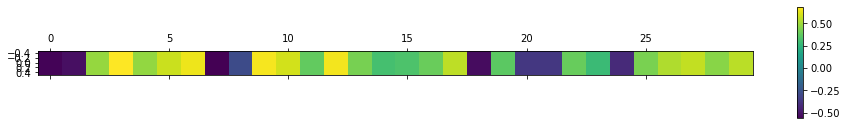

In [149]:
wgrad_tr.shape

(5000, 3617)

In [40]:
ngr = np.linalg.norm(wgrad_tr,axis=1)
ngr2 = np.linalg.norm(wgrad_tr2,axis=1)
ngr3 = np.linalg.norm(wgrad_tr3,axis=1)

In [41]:
ngrte = np.linalg.norm(wgrad_te,axis=1)
ngr2te = np.linalg.norm(wgrad_te2,axis=1)
ngr3te = np.linalg.norm(wgrad_te3,axis=1)

In [42]:
ngr.shape

(700,)

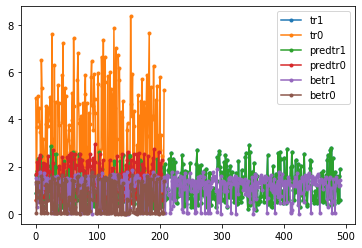

In [43]:
plt.plot(ngr[y_tr==1],marker='.',label='tr1')
plt.plot(ngr[y_tr==0],marker='.',label='tr0')
plt.plot(ngr2[y_tr==1],marker='.',label='predtr1')
plt.plot(ngr2[y_tr==0],marker='.',label='predtr0')
plt.plot(ngr3[y_tr==1],marker='.',label='betr1')
plt.plot(ngr3[y_tr==0],marker='.',label='betr0')
plt.legend()
plt.show()

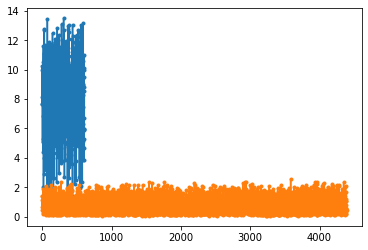

In [164]:
plt.plot(ngr[y_tr==1],marker='.')
plt.plot(ngr[y_tr==0],marker='.')
# plt.plot(ngr2[y_tr==1],marker='.')
# plt.plot(ngr2[y_tr==0],marker='.')
plt.show()

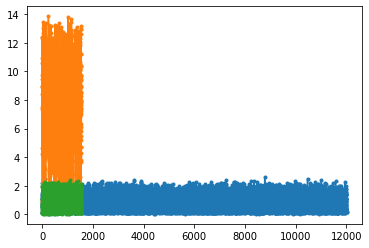

In [171]:
plt.plot(ngrte[y_te==0],marker='.')
plt.plot(ngrte[y_te==1],marker='.')
plt.plot(ngr2te[y_te==1],marker='.')
# plt.plot(ngr2te[y_te==0],marker='.')
plt.show()

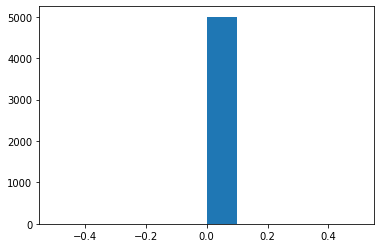

In [147]:
plt.hist(out_tr)
plt.show()

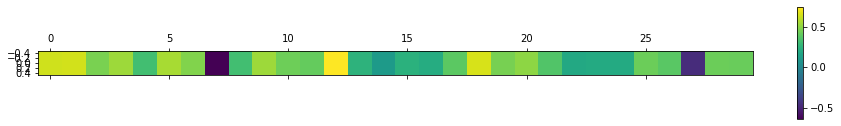

In [137]:
for i in range(30):
    print("-"*10,i,'-'*10)
    print(out_te[i],out_te2[i])
    print(y_te[i],y_te2[i])

---------- 0 ----------
0.0 0.0
0.0 0.0
---------- 1 ----------
0.0 0.0
0.0 0.0
---------- 2 ----------
0.0 0.0
0.0 0.0
---------- 3 ----------
0.0 0.0
0.0 0.0
---------- 4 ----------
0.0 0.0
0.0 0.0
---------- 5 ----------
0.0 0.0
0.0 0.0
---------- 6 ----------
0.0 0.0
0.0 0.0
---------- 7 ----------
0.0 0.0
0.0 0.0
---------- 8 ----------
0.0 0.0
0.0 0.0
---------- 9 ----------
0.0 0.0
1.0 1.0
---------- 10 ----------
0.0 0.0
0.0 0.0
---------- 11 ----------
0.0 0.0
0.0 0.0
---------- 12 ----------
0.0 0.0
0.0 0.0
---------- 13 ----------
0.0 0.0
0.0 0.0
---------- 14 ----------
0.0 0.0
0.0 0.0
---------- 15 ----------
0.0 0.0
0.0 0.0
---------- 16 ----------
0.0 0.0
0.0 0.0
---------- 17 ----------
0.0 0.0
0.0 0.0
---------- 18 ----------
0.0 0.0
0.0 0.0
---------- 19 ----------
0.0 0.0
0.0 0.0
---------- 20 ----------
0.0 0.0
0.0 0.0
---------- 21 ----------
0.0 0.0
1.0 1.0
---------- 22 ----------
0.0 0.0
0.0 0.0
---------- 23 ----------
0.0 0.0
1.0 1.0
---------- 24 ----------
0

In [124]:
sim_mat[20]

array([-0.43377766, -0.6402937 , -0.6737147 , ..., -0.40176624,
       -0.42649603, -0.49073365], dtype=float32)

In [49]:
corr_grad(wgrad_tr,y_tr,z_tr)
corr_grad(grdic_tr[param_names[4]],y_tr,z_tr)

0.12494504
2.672454
0.9646204
0.35256904
0.08055194
[[ 1.0000001   0.94002295 -0.9167206   0.9531899   0.9533583 ]
 [ 0.94002295  1.         -0.99802256  0.9356355   0.8566328 ]
 [-0.9167206  -0.99802256  0.9999999  -0.92020833 -0.827645  ]
 [ 0.9531899   0.9356355  -0.92020833  1.          0.8174625 ]
 [ 0.9533583   0.8566328  -0.827645    0.8174625   1.0000005 ]]
0.0151879005
0.47666842
0.1822464
0.04007395
0.0101318
[[ 1.          0.90282583 -0.87972754  0.96429706  0.9710466 ]
 [ 0.90282583  0.99999976 -0.9986991   0.8660585   0.88077545]
 [-0.87972754 -0.9986991   0.99999994 -0.8433052  -0.8587786 ]
 [ 0.96429706  0.8660585  -0.8433052   1.0000002   0.8731137 ]
 [ 0.9710466   0.88077545 -0.8587786   0.8731137   0.99999976]]


In [52]:
corr_grad(wgrad_te,y_te,z_te)
for pr in param_names:
    print("="*3+pr+"="*3)
    corr_grad(grdic_te[pr],y_te,z_te)

0.17875165
2.6023867
0.94645303
0.6042935
0.124291204
[[ 1.0000006   0.8350612  -0.743182    0.8487457   0.76607794]
 [ 0.8350612   1.0000001  -0.98870695  0.93115145  0.3694028 ]
 [-0.743182   -0.98870695  1.0000004  -0.9012466  -0.24057913]
 [ 0.8487457   0.93115145 -0.9012466   1.0000001   0.31031874]
 [ 0.76607794  0.3694028  -0.24057913  0.31031874  1.0000005 ]]
===lin1_w===
0.14808467
1.8793738
0.6628121
0.4590749
0.10737496
[[ 0.9999998   0.8372402  -0.7277807   0.8450867   0.8206413 ]
 [ 0.8372402   1.0000002  -0.98435295  0.8920406   0.48986936]
 [-0.7277807  -0.98435295  1.0000002  -0.84642744 -0.3499239 ]
 [ 0.8450867   0.8920406  -0.84642744  0.9999999   0.38800243]
 [ 0.8206413   0.48986936 -0.3499239   0.38800243  1.0000004 ]]
===lin1_b===
0.05300493
0.8552434
0.30532172
0.18618532
0.024589255
[[ 1.          0.96335953 -0.94317216  0.96495533  0.8679007 ]
 [ 0.96335953  0.99999994 -0.9977422   0.9776295   0.7451809 ]
 [-0.94317216 -0.9977422   1.         -0.96962667 -0.70

In [54]:
corr_grad(wgrad_te4,y_te4,z_te4)
for pr in param_names:
    print("="*3+pr+"="*3)
    corr_grad(grdic_te4[pr],y_te4,z_te4)

44.007088
46.55004
43.49181
48.03361
43.19407
[[1.         0.9798584  0.99552155 0.9873687  0.9990295 ]
 [0.9798584  1.0000001  0.95659184 0.9773277  0.97617024]
 [0.99552155 0.95659184 1.         0.9782852  0.99585104]
 [0.9873687  0.9773277  0.9782852  1.0000001  0.97943115]
 [0.9990295  0.97617024 0.99585104 0.97943115 1.        ]]
===lin1_w===
31.116966
34.229126
30.02617
35.040245
30.343048
[[1.0000001  0.9874338  0.99682003 0.9816376  0.99848247]
 [0.9874338  1.0000002  0.97170067 0.974289   0.98449516]
 [0.99682003 0.97170067 0.9999999  0.9760015  0.99603367]
 [0.9816376  0.974289   0.9760015  0.9999999  0.9696432 ]
 [0.99848247 0.98449516 0.99603367 0.9696432  0.99999964]]
===lin1_b===
14.282289
15.831202
13.629878
16.288977
13.79568
[[0.9999999  0.99691534 0.9991868  0.99714315 0.9997514 ]
 [0.99691534 0.9999998  0.9929399  0.9949437  0.9964087 ]
 [0.9991868  0.9929399  1.0000001  0.99588186 0.9990713 ]
 [0.99714315 0.9949437  0.99588186 0.9999999  0.99521106]
 [0.9997514  0.9

In [163]:
wgrad_arr = np.array(torch.cat(wgrad_list,dim=0).numpy(),dtype=np.float32)

In [164]:
wmean = np.mean(wgrad_arr,axis=0)
wmean_y0 = np.mean(wgrad_arr[y_arr==0],axis=0)
wmean_y1 = np.mean(wgrad_arr[y_arr==1],axis=0)

wmean_z0 = np.mean(wgrad_arr[z_arr==0],axis=0)
wmean_z1 = np.mean(wgrad_arr[z_arr==1],axis=0)

In [165]:
aa = [wmean,wmean_y0,wmean_y1,wmean_z0,wmean_z1]
for a in aa:
    print(np.linalg.norm(a))

0.13962102
4.8208594
1.0861616
0.21773386
0.09296312


In [170]:
from sklearn.metrics.pairwise import cosine_similarity
aan = np.row_stack(aa)
print(cosine_similarity(aan,aan))

[[ 1.0000001   0.671366   -0.57849014  0.96020055  0.5429791 ]
 [ 0.671366    1.0000004  -0.992907    0.8454311  -0.23911381]
 [-0.57849014 -0.992907    0.9999998  -0.7764525   0.3502759 ]
 [ 0.96020055  0.8454311  -0.7764525   1.0000006   0.2868148 ]
 [ 0.5429791  -0.23911381  0.3502759   0.2868148   0.9999997 ]]


In [71]:
calculate_overall_accuracy(out_tr,y_tr)

0.7364

In [72]:
calculate_overall_accuracy(out_tr[z_tr==0],y_tr[z_tr==0])

0.7331341797361215

In [73]:
calculate_overall_accuracy(out_tr[z_tr==1],y_tr[z_tr==1])

0.7385926792578974

In [132]:
def calculate_overall_accuracy(pred,y):
    pred = pred.flatten()
    return np.sum(pred==y)/len(pred)

In [177]:
gdl_arr = torch.cat(grad_dic['lin4_w'],dim=0).numpy()
print(gdl_arr.shape)

(10000, 32)


In [178]:
lmean = np.mean(gdl_arr,axis=0)
lmean_y0 = np.mean(gdl_arr[y_arr==0],axis=0)
lmean_y1 = np.mean(gdl_arr[y_arr==1],axis=0)

lmean_z0 = np.mean(gdl_arr[z_arr==0],axis=0)
lmean_z1 = np.mean(gdl_arr[z_arr==1],axis=0)

In [179]:
from sklearn.metrics.pairwise import cosine_similarity
aal = [lmean,lmean_y0,lmean_y1,lmean_z0,lmean_z1]
for a in aal:
    print(np.linalg.norm(a))

aanl = np.row_stack(aal)
print(cosine_similarity(aanl,aanl))

0.0093537625
0.5467532
0.12926793
0.016414464
0.010477241
[[ 1.          0.5711562  -0.5087406   0.87814206  0.27278316]
 [ 0.5711562   1.         -0.99724925  0.8935682  -0.63254535]
 [-0.5087406  -0.99724925  1.0000002  -0.85789883  0.68806326]
 [ 0.87814206  0.8935682  -0.85789883  0.99999994 -0.22071445]
 [ 0.27278316 -0.63254535  0.68806326 -0.22071445  1.        ]]


In [182]:
type(grad_dic) == dict

True

In [71]:
y_arr2.shape

(13564,)

## visualize

In [171]:
from sklearn.manifold import TSNE

In [172]:
from sklearn.decomposition import PCA

def viz_plot_grad(grad_list, c_idx = None,method='pca',lywise=False,metric='euclidean',param_names = None):
    if lywise:
        print("lywise")
        assert param_names is not None
        for i, pn in enumerate(param_names):
#             print(grad_list[pn])
            grad_arr = np.array(torch.cat(grad_list[pn],dim=0).numpy(),dtype=np.float32)
            draw_plot(grad_arr,c_idx,method,metric,title=pn)
    else:
        grad_arr = np.array(torch.cat(grad_list,dim=0).numpy(),dtype=np.float32)
#         print(grad_arr.shape)
        draw_plot(grad_arr,c_idx,method,metric)

def draw_plot(grad_arr, c_idx, method,metric = 'euclidean',title =None):
    assert method in ['pca','tsne']
    if method == 'pca':
        grad_emb = PCA(n_components=2,whiten=False).fit_transform(grad_arr)
    else:
        grad_emb = TSNE(n_components=2,learning_rate='auto',init = 'random',metric=metric).fit_transform(grad_arr)
    fig,ax = plt.subplots()
    scatter = ax.scatter(grad_emb[:,0],grad_emb[:,1],c=c_idx)
    legend1 = ax.legend(*scatter.legend_elements())
    ax.add_artist(legend1)
    if title is not None:
        plt.title(title)
    plt.show()

In [105]:
len(wgrad_list)

157

(10000, 3617)


/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


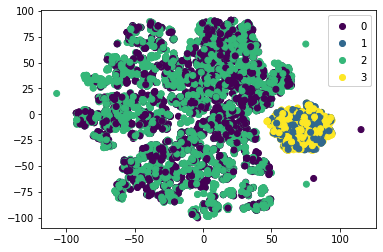

In [111]:
viz_plot_grad(wgrad_list,y_arr+2*z_arr,method='tsne',metric='cosine')

(13564, 3617)


/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


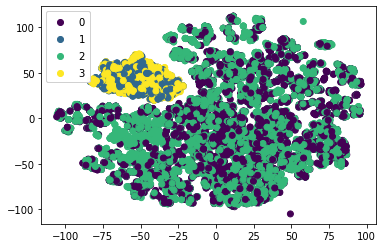

In [112]:
viz_plot_grad(wgrad_list2,y_arr2+2*z_arr2,method='tsne',metric='cosine')

(10000, 3617)


/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


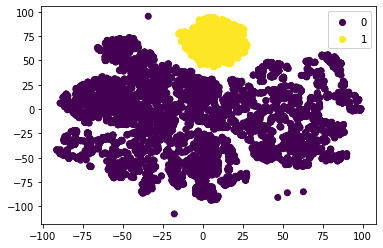

In [109]:
viz_plot_grad(wgrad_list,y_arr,method='tsne',metric='cosine')

(10000, 3617)


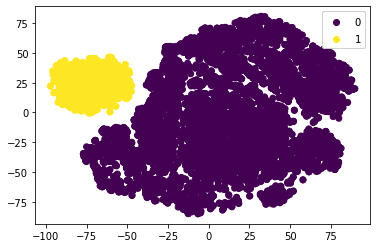

In [107]:
viz_plot_grad(wgrad_list,y_arr,method='tsne')

lywise


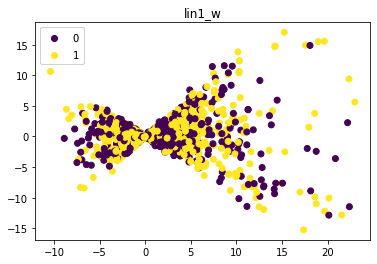

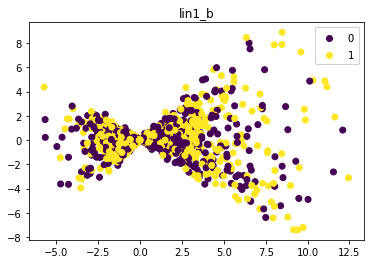

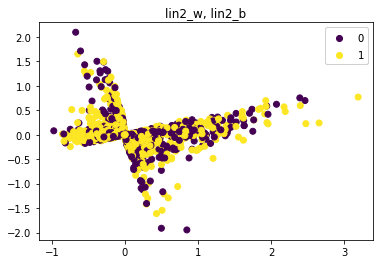

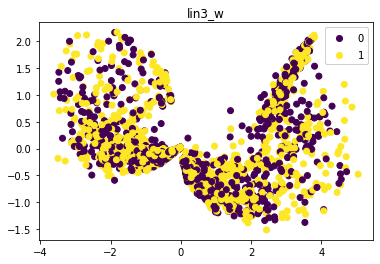

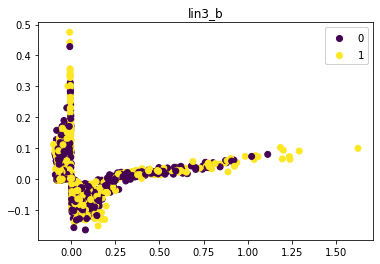

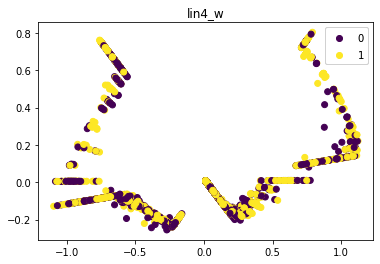

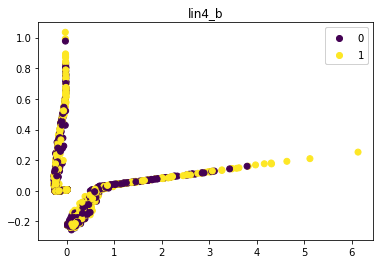

In [95]:
viz_plot_grad(grad_dic,z_arr,lywise=True,param_names =param_names)

lywise


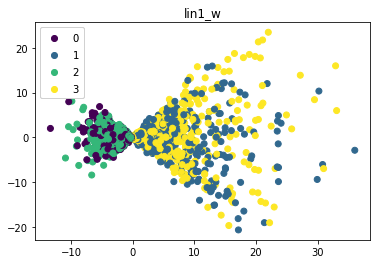

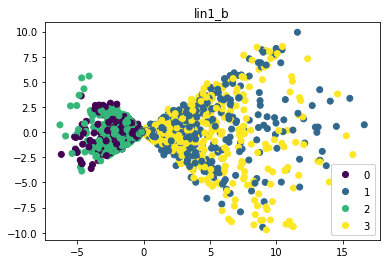

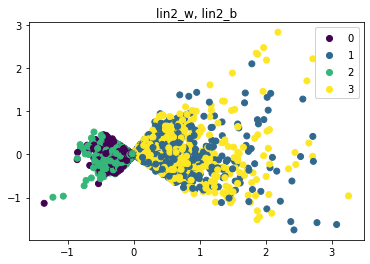

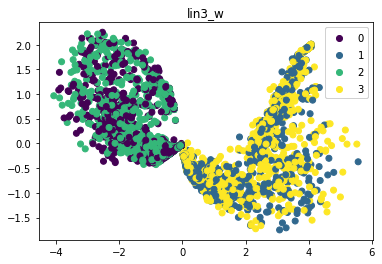

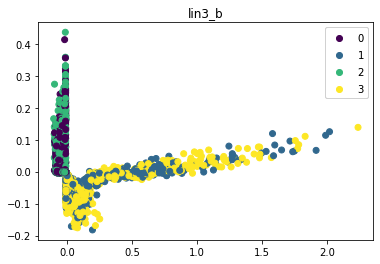

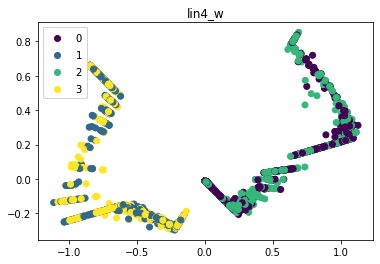

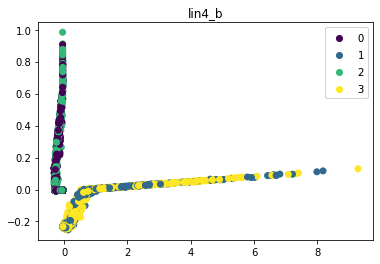

In [113]:
viz_plot_grad(grad_dic2,y_arr2+2*z_arr2,lywise=True,param_names =param_names)

lywise


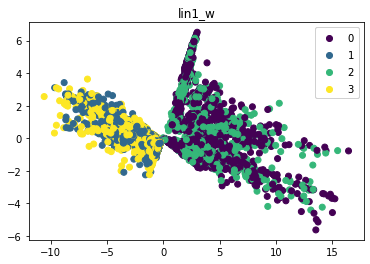

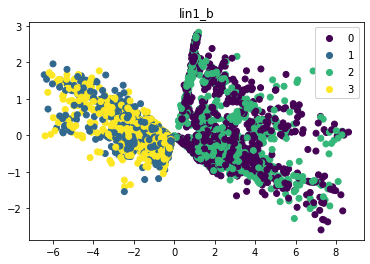

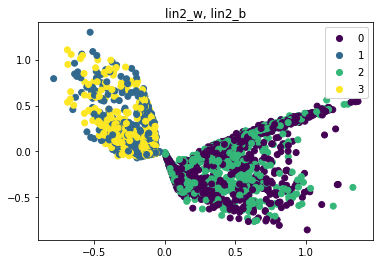

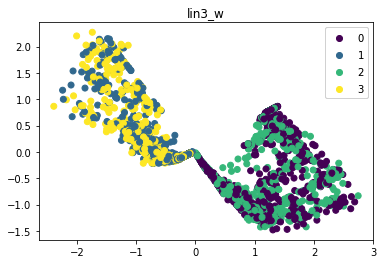

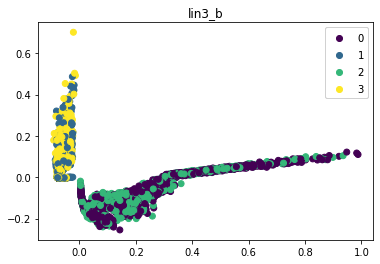

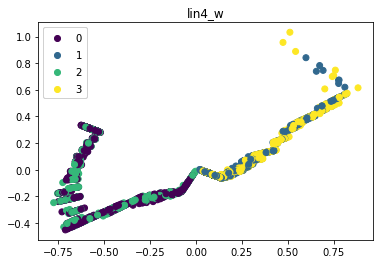

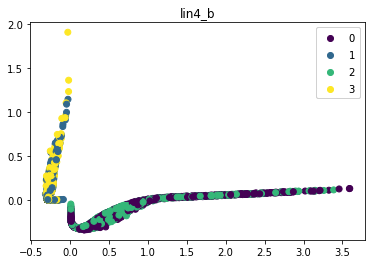

In [174]:
viz_plot_grad(grad_dic,y_arr+2*z_arr,lywise=True,param_names =param_names)